**SVG dataset generator**

Install dependencies

In [ ]:
!pip3 install -q drawSvg

In [ ]:
import re
import numpy as np
import drawSvg as draw
import pandas as pd
from IPython import display

Parameters

In [ ]:
canvas_size = np.array([200, 200])

class Rectangle:
  def as_object(self, center, size, color, order):
    return draw.Rectangle(*(center - (np.array(size) / 2).astype(int)), *size, fill=color, stroke_width=order)

class Circle:
  def as_object(self, center, size, color, order):
    return draw.Circle(*center, int(size[0] / 2.), fill=color, stroke_width=order)

shapes = {
    'rectangle': Rectangle(),
    'circle': Circle()
}

colors = {
  'red': (255, 0, 0),
  'blue': (0, 0, 255),
  'green': (0, 255, 0),
  'yellow': (255, 255, 0),
  'cyan': (0, 255, 255),
  'pink': (255, 0, 255),
  'purple': (128, 0, 128),
  'orange': (255, 165, 0),
  'gray': (128, 128, 128),
  'black': (0, 0, 0)
}

sizes = {
  'tiny': .05 * canvas_size,
  'small': .1 * canvas_size,
  'medium': .3 * canvas_size,
  'large': .5 * canvas_size
}

horizontal_positions = {
  'left': (.16 * canvas_size[0], 0),
  'center': (.5 * canvas_size[0], 0),
  'right': (.84 * canvas_size[0], 0),
  '': (.5 * canvas_size[0], 0)
}

vertical_positions = {
  'top': (0, .84 * canvas_size[1]),
  'center': (0, .5 * canvas_size[1]),
  'bottom': (0, .16 * canvas_size[1]),
  '': (0, .5 * canvas_size[1])
}

OTHER_DIM = (.9, 1.1)

def to_left(pos1, size1, size2):
  x2 = pos1[0] - (size1[0] // 2 + size2[0] // 2)
  return (x2 - np.random.randint(0, max(1, x2)), int(pos1[1] * np.random.uniform(*OTHER_DIM)))

def to_right(pos1, size1, size2):
  x2 = pos1[0] + (size1[0] // 2 + size2[0] // 2)
  return (x2 + np.random.randint(0, max(1, (canvas_size[0] - x2) + 1)), int(pos1[1] * np.random.uniform(*OTHER_DIM)))

def below(pos1, size1, size2):
  y2 = pos1[1] - (size1[1] // 2 + size2[1] // 2)
  return (int(pos1[0] * np.random.uniform(*OTHER_DIM)), y2 - np.random.randint(0, max(1, y2)))

def above(pos1, size1, size2):
  y2 = pos1[1] + (size1[1] // 2 + size2[1] // 2)
  return (int(pos1[0] * np.random.uniform(*OTHER_DIM)), y2 + np.random.randint(0, max(1, (canvas_size[1] - y2) + 1)))

position_relations = {
  'to left': to_left,
  'to right': to_right,
  'below': below,
  'above': above
  # 'near': 
}

overlap_relations = {
    'in front': lambda a: a.order + 1,
    'behind': lambda a: a.order - 1
}

class Params:
  def __init__(self, shape, x, y, size, color, order):
    self.shape = shape
    self.x = list(x)
    self.y = list(y)
    self.size = size
    self.color = color
    self.order = 0

    self.adjectives = ' '.join(self.shuffle_adjectives())

  def shuffle_adjectives(self):
      adjectives = [self.color[0], np.random.choice(size_synonyms[self.size[0]])]
      np.random.shuffle(adjectives)
      return adjectives

  @staticmethod
  def fromKeys(shape='rectangle', x='center', y='center', size='medium', color='black'):
    return Params((shape, shapes[shape]), (x, horizontal_positions[x]),
                  (y, vertical_positions[y]), (size, sizes[size]), (color, colors[color]), order=0)

class ObjParam:
  def __init__(self, drawable, position, size, color, order):
    self.drawable = drawable
    self.position = position
    self.size = size
    self.color = color
    self.order = order

Synonyms

In [ ]:
size_synonyms = {
    'tiny': ['tiny', 'mini', 'toy'],
    'small': ['small', 'little'],
    'medium': ['medium', 'average', 'normal'],
    'large': ['large', 'big', 'huge']
}

vertical_positions_synonyms = {
  'top': ['top', 'upper'],
  'center': ['center', 'middle'],
  'bottom': ['bottom', 'lower'],
  '': ['']
}

conjunction_synonyms = [' and', ',']

Labels generation

In [ ]:
def make_label_with_position(params):
  vpos = np.random.choice(vertical_positions_synonyms[params.y[0]])
  pos = f'{vpos} {params.x[0]}' if params.y[0] != params.x[0] else vpos
  pos = pos.strip()
  pronoun = 'in' if pos != '' else ''

  return f'{make_label(params)} {pronoun} {pos}'.strip()

def make_label_with_relation(params, relation):
  return f'{make_label(params)} {relation[0]}'

def make_label(params):
  return f'{params.adjectives} {params.shape[0]}'

def generate_label(params, relations, targets, adjecent):
  assert len(params) == len(relations) == len(targets) == len(adjecent)

  label = f'{make_label_with_position(params[0])}'
  for i in range(1, len(params)):
    if adjecent[i]:
      label += f'{np.random.choice(conjunction_synonyms)} {make_label_with_relation(params[i], relations[i])}'
      if np.random.uniform(0, 1) > .5:
        label += f' {make_label(targets[i])}'
    else:
      label += f'{np.random.choice(conjunction_synonyms)} {make_label_with_relation(params[i], relations[i])} {make_label(targets[i])}'

  return label

Object generation

In [ ]:
def random_pair(pairs):
  return list(pairs.items())[np.random.randint(0, len(pairs))]

def random_params():
  color = random_pair(colors)
  size = random_pair(sizes)
  shape = random_pair(shapes)
  hpos = random_pair(horizontal_positions)
  vpos = random_pair(vertical_positions)

  return Params(shape, hpos, vpos, size, color, 0)

def make_object_from_params(params, rand_pos=True):
  def rand_n(values, low, high):
    return [int(value + np.random.uniform(low=low * modifier, high=high * modifier)) for value, modifier in zip(values, canvas_size)]

  def rand_rgb(color):
    return np.clip(color + np.random.randint(-15, 15 + 1, size=3), 0, 255)

  position = rand_n(np.sum([params.x[1], params.y[1]], axis=0), -.05, .05) if rand_pos else np.sum([params.x[1], params.y[1]], axis=0)
  size = rand_n(params.size[1], -.02, .02)
  color = f'rgb{tuple(rand_rgb(params.color[1]))}'

  return ObjParam(params.shape[1].as_object(position, size, color, params.order), position, size, color, params.order)

def convert_to_code(canvas):
  svg = re.sub('\n', '', canvas.asSvg())
  svg = re.sub('^.*</defs>', '', svg)
  return re.sub('</svg>', '', svg)

def apply_relation(object1, params2, relation):
  new_position = relation[1](object1.position, object1.size, params2.size[1])
  return apply_new_position(object1, params2, new_position)

def apply_new_position(object1, params2, new_position):
  params2.x[1] = (np.clip(int(new_position[0]), 0, canvas_size[0]), 0)
  params2.y[1] = (0, np.clip(int(new_position[1]), 0, canvas_size[1]))
  return params2

def generate_objects(canvas, n):
  # 'to_left' -> obj2 to the left of obj1
  # 'above' -> obj2 above the obj1
  params = [random_params() for i in range(n)]

  object1 = make_object_from_params(params[0])

  objects = [object1]
  relations = [None]
  targets = [None]
  adjecent = [None]
  for i in range(1, n):
    target_index = np.random.randint(0, len(objects))
    adjecent.append(target_index == len(objects) - 1)
    targets.append(params[target_index])

    is_x_y = np.random.uniform(0, 1) > .5

    if is_x_y:
      xyrelation = random_pair(position_relations)
      relations.append(xyrelation)

      apply_relation(objects[target_index], params[i], xyrelation)
      objects.append(make_object_from_params(params[i], False))
    else:
      zrelation = random_pair(overlap_relations)
      relations.append(zrelation)

      apply_new_position(objects[target_index], params[i], objects[target_index].position)

      params[i].order = zrelation[1](objects[target_index])
      objects.append(make_object_from_params(params[i], False))

  objects.reverse()
  for obj in objects:
    canvas.append(obj.drawable)

  X = generate_label(params, relations, targets, adjecent)
  y = convert_to_code(canvas)
  return X, y

Canvas creation

In [ ]:
def make_canvas():
  canvas = draw.Drawing(*canvas_size, displayInline=False)
  # canvas.append(draw.Rectangle(0, 0, *canvas_size, fill='white', stroke_width=2, stroke='black')) # For display purposes
  return canvas

canvasx = make_canvas()

X, y = generate_objects(canvasx, 2)
print('X:', X, '\ny:', y)
canvasx

X: small purple circle in left, red tiny rectangle in front small purple circle 
y: <rect x="33" y="-112" width="12" height="13" fill="rgb(251, 9, 0)" stroke-width="1" /><circle cx="39" cy="-105" r="11" fill="rgb(119, 2, 140)" stroke-width="0" />


Tests

In [ ]:
assert make_object_from_params(Params.fromKeys(y='top')).position[1] > .5 * canvas_size[1] # Top
assert make_object_from_params(Params.fromKeys(y='bottom')).position[1] < .5 * canvas_size[1] # Bottom
assert make_object_from_params(Params.fromKeys(x='left')).position[0] < .5 * canvas_size[0] # Left
assert make_object_from_params(Params.fromKeys(x='right')).position[0] > .5 * canvas_size[0] # Right

obj = make_object_from_params(Params.fromKeys(x='center'))
assert apply_relation(obj, Params.fromKeys(), ('to left', position_relations['to left'])).x[1][0] < obj.position[0] # To Left

obj = make_object_from_params(Params.fromKeys(x='center'))
assert apply_relation(obj, Params.fromKeys(), ('to right', position_relations['to right'])).x[1][0] > obj.position[0] # To Right

obj = make_object_from_params(Params.fromKeys(y='center'))
assert apply_relation(obj, Params.fromKeys(), ('below', position_relations['below'])).y[1][1] < obj.position[1] # Below

obj = make_object_from_params(Params.fromKeys(y='center'))
assert apply_relation(obj, Params.fromKeys(), ('above', position_relations['above'])).y[1][1] > obj.position[1] # Above

Generate dataset

In [ ]:
def generate_dataset(file_name, n):
  data = pd.DataFrame(np.random.randn(n, 2), columns=['x', 'y'])
  
  for i in range(n):
    X, y = generate_objects(make_canvas(), np.random.choice([1] * 1 + [2] * 1 + [3] * 3 + [4] * 3)) # Proportions
    data.loc[i] = [X, y]

  data.to_csv(file_name)

SAMPLES = 1500000
DATASET_PATH = f'drive/MyDrive/svg/order_svg_dataset_{int(SAMPLES / 1e3)}k.csv'
generate_dataset(DATASET_PATH, SAMPLES)

Show SVG

X: orange small circle in center, yellow little circle in front orange small circle, big cyan rectangle in front orange small circle 
y: <rect x="58" y="-157" width="99" height="101" fill="rgb(0, 242, 255)" stroke-width="1" /><circle cx="107" cy="-106" r="10" fill="rgb(242, 255, 0)" stroke-width="1" /><circle cx="107" cy="-106" r="9" fill="rgb(255, 165, 0)" stroke-width="0" />


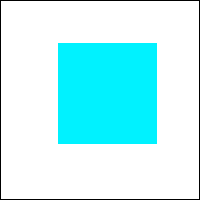

In [ ]:
import svg_generator

def sample_from_dataset(file_name, i):
  data = pd.read_csv(file_name)
  sample = data.loc[i]
  return sample['x'], sample['y']

X, y = sample_from_dataset(DATASET_PATH, np.random.randint(0, SAMPLES))
print('X:', X, '\ny:', y)
svg_generator.TextGenerator.display_code(y)